Here it try to reduce complexity of the model by groupping engagement categories into 3 engagement types: engaged positive, engaged negative and not engaged. 

The goal is to see wether this acction will improve the accuracy and then decide wether we want to farther fine tune it. 

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random

from torchvision import transforms

In [4]:
df = pd.read_pickle('combined_data_balanced.pkl')

In [5]:
df.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image'],
      dtype='object')

In [6]:
df['label'].unique()

array(['irritation', 'wrath', 'annoyance', 'rage', 'aggravation', 'anger',
       'resentment', 'grumpiness', 'frustration', 'fury', 'hostility',
       'exasperation', 'outrage', 'grouchiness', 'spite', 'lust',
       'desire', 'longing', 'infatuation', 'passion', 'loneliness',
       'unhappiness', 'disappointment', 'insult', 'rejection',
       'agitation', 'defeat', 'gloom', 'alienation', 'bitterness', 'hate',
       'disgust', 'dislike', 'contempt', 'scorn', 'displeasure', 'envy',
       'loathing', 'jealousy', 'revulsion', 'nervousness', 'alarm',
       'fear', 'fright', 'horror', 'terror', 'dread', 'hysteria',
       'dismay', 'apprehension', 'worry', 'panic', 'tenseness',
       'uneasiness', 'anxiety', 'suffering', 'hurt', 'anguish', 'agony',
       'insecurity', 'distress', 'torment', 'attraction', 'liking',
       'excitement', 'hope', 'optimism', 'eagerness', 'zeal', 'arousal',
       'joy', 'zest', 'cheerfulness', 'happiness', 'elation', 'rapture',
       'enjoyment', 'gla

In [7]:
df.emotion_category.unique()

array(['Anger / Irritation', 'Desire / Passion',
       'Disengagement / Negative Mood', 'Disgust / Aversion',
       'Fear / Anxiety', 'Hurt / Pain / Suffering',
       'Interest / Engagement', 'Joy / Positive Engagement',
       'Love / Affection / Caring', 'Neutral / Not Engaged',
       'Pride / Accomplishment', 'Sadness / Grief',
       'Shame / Guilt / Embarrassment', 'Surprise / Amazement'],
      dtype=object)

In [8]:
# Mapping dictionary
engagement_mapping = {
    'Anger / Irritation': 'engaged-negative',
    'Desire / Passion': 'engaged-positive',
    'Disengagement / Negative Mood': 'not engaged',
    'Disgust / Aversion': 'engaged-negative',
    'Fear / Anxiety': 'engaged-negative',
    'Hurt / Pain / Suffering': 'engaged-negative',
    'Interest / Engagement': 'engaged-positive',
    'Joy / Positive Engagement': 'engaged-positive',
    'Love / Affection / Caring': 'engaged-positive',
    'Neutral / Not Engaged': 'not engaged',
    'Pride / Accomplishment': 'engaged-positive',
    'Sadness / Grief': 'engaged-negative',
    'Shame / Guilt / Embarrassment': 'engaged-negative',
    'Surprise / Amazement': 'engaged-positive'
}

# Apply mapping to create a new column
df['engagement_type'] = df['emotion_category'].map(engagement_mapping)

# Optional: check the distribution
print(df['engagement_type'].value_counts())


engagement_type
engaged-negative    4836
engaged-positive    4836
not engaged         1612
Name: count, dtype: int64


In [9]:
# Step 1: Define the target sample size
min_class_size = df['engagement_type'].value_counts().min()

# Step 2: Sample each class down to the minimum size
df_balanced = (
    df.groupby('engagement_type', group_keys=False)
      .apply(lambda x: x.sample(n=min_class_size, random_state=42))
      .reset_index(drop=True)
)

# Step 3: Check the balance
print(df_balanced['engagement_type'].value_counts())

engagement_type
engaged-negative    1612
engaged-positive    1612
not engaged         1612
Name: count, dtype: int64


C:\Users\alina\AppData\Local\Temp\ipykernel_7784\3667488993.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42))


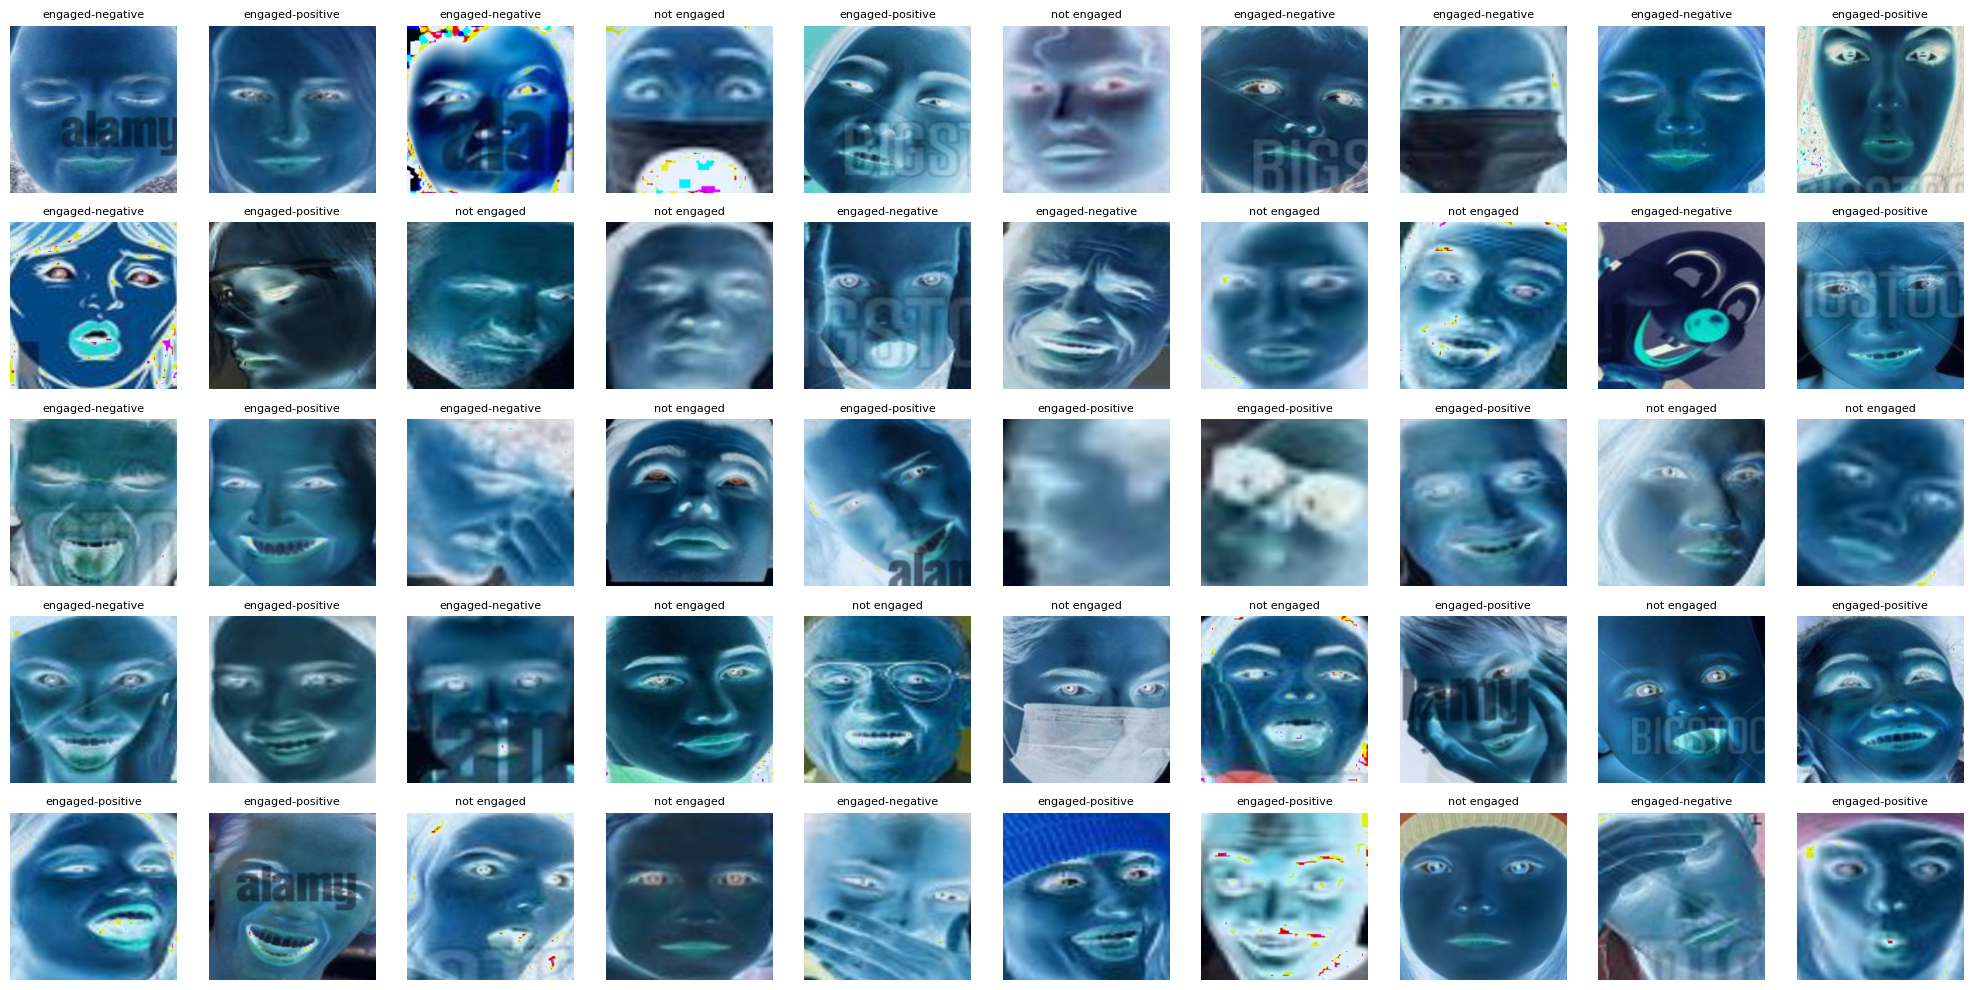

In [10]:
# Printing 50 random pisc ans labels


sample_df = df_balanced.sample(n=50, random_state=42).reset_index(drop=True)

# Step 2: Create plot
plt.figure(figsize=(20, 10))

for i in range(50):
    img_tensor = sample_df.loc[i, 'image']
    label = sample_df.loc[i, 'engagement_type']

    # If normalized, skip this step or apply mean/std unnormalization as needed
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] for display

    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# --- Step 1: Define transforms for tensor images ---

from torchvision.transforms import functional as F

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: F.resize(x, [256, 256])),
    transforms.Lambda(lambda x: F.center_crop(x, [224, 224])),
    transforms.Lambda(lambda x: F.hflip(x) if torch.rand(1) < 0.5 else x),
    transforms.Lambda(lambda x: F.normalize(x, mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225]))
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: F.resize(x, [256, 256])),
    transforms.Lambda(lambda x: F.center_crop(x, [224, 224])),
    transforms.Lambda(lambda x: F.normalize(x, mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225]))
])


In [18]:
# --- Step 2: Dataset class ---
class EngagementDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.images = list(dataframe['image'].values)
        self.labels = LabelEncoder().fit_transform(dataframe['engagement_type'].values)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, torch.Tensor):
            image = image.float()
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [19]:
class EmotionNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:
# Step 3: Prepare your dataframe
df_balanced = df_balanced[['image', 'engagement_type']]  # Keep only needed columns
train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.15,
    stratify=df_balanced['engagement_type'],
    random_state=42
)

train_dataset = EngagementDataset(train_df, transform=train_transform)
val_dataset = EngagementDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [21]:
# Step 4: Initialize model, loss, optimizer
num_classes = len(df_balanced['engagement_type'].unique())
model = EmotionNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Step 5: Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_acc = 100. * correct_val / total_val
    print(f"→ Validation Acc: {val_acc:.2f}%")


Epoch 1, Loss: 5.9405, Train Acc: 33.89%
→ Validation Acc: 33.20%
Epoch 2, Loss: 1.0974, Train Acc: 33.77%
→ Validation Acc: 31.96%
Epoch 3, Loss: 1.0898, Train Acc: 35.91%
→ Validation Acc: 34.71%
Epoch 4, Loss: 1.0747, Train Acc: 41.09%
→ Validation Acc: 35.81%
Epoch 5, Loss: 1.0455, Train Acc: 43.67%
→ Validation Acc: 33.88%
Epoch 6, Loss: 0.9605, Train Acc: 50.90%
→ Validation Acc: 35.54%
Epoch 7, Loss: 0.8905, Train Acc: 56.84%
→ Validation Acc: 35.81%
Epoch 8, Loss: 0.8018, Train Acc: 62.60%
→ Validation Acc: 36.91%
Epoch 9, Loss: 0.7205, Train Acc: 68.15%
→ Validation Acc: 36.50%
Epoch 10, Loss: 0.5970, Train Acc: 75.50%
→ Validation Acc: 37.33%


# Visualising predictions to see where the model goes wrong

In [23]:
print(model)

EmotionNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [24]:
for name, module in model.named_modules():
    print(name, ":", module)


 : EmotionNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
features : Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo